<div align="center">
<h1>Appendix</h1>
</div>

In [15]:
# Import necessary packages and modules
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import os

In [16]:
# File path-related constants
General_Path = "D://mahtab's university//year2//semester1//machine_learning//ML"
Image_Path = os.path.join(General_Path, 'images')

# Image-related constants
Image_Height = 484
Image_Width = 644
File_Extension = '.bmp'
Cropped_Left = int(Image_Width*0.45)
Cropped_Right = int(Image_Width*0.85)
Cropped_Top = int(Image_Height*0.1)
Cropped_Bottom = int(Image_Height*0.65)

# Signal related constants
Min_Wavelength = 470
Max_Wavelength = 740
Num_Wavelengths = 271
Wavelengths = np.linspace(Min_Wavelength, Max_Wavelength, Num_Wavelengths)


In [17]:
# Function used to return the Gray values (i.e. intensity) of a specific pixel for a given image
def gray_values(wavelength, pixel):
    # print(f'Extracting the gray values for image at {image_path}\n(Target pixel: {pixel}')
    this_image_path = os.path.join(Image_Path, str(int(wavelength)) + '.bmp')
    this_image = Image.open(this_image_path)
    rgb = this_image.getpixel(pixel)
    gray = sum(rgb[:3])
    return gray

In [18]:
# Parameters
Sampling_Factor = 10
Testing_Ratio = 0.2                 # Proportion of data points to be considered for testing
seed = 180923
Num_Folds = 5                       # Number of folds for k-cross validation
k = 5
show_folds = False

In [19]:
# Constants
Num_Pixels = Sampling_Factor**2
inter_num = Num_Wavelengths*k
Num_Testing_Signals = int(Testing_Ratio*inter_num)
Num_TrainNVal_Signals = Num_Wavelengths - Num_Testing_Signals

<div align="center">
    <h2>Preprocessing</h2>
</div>


In [20]:
# Construct NumPy array containing an evenly spaced set of points corresponding to pixels on the image
x_coords = np.linspace(Cropped_Left, Cropped_Right, Sampling_Factor)
y_coords = np.linspace(Cropped_Top, Cropped_Bottom, Sampling_Factor)
x_grid, y_grid = np.meshgrid(x_coords, y_coords)
pixels = np.column_stack((x_grid.flatten(), y_grid.flatten()))

<div align="center">
    <h3>Interpolation</h3>
</div>


In [21]:
# defining arrays for the feautures and interpolated labels
y_interpolated = np.linspace(Min_Wavelength, Max_Wavelength, inter_num)
X_interpolated= np.zeros((inter_num, Num_Pixels))
X = np.zeros((Num_Wavelengths, Num_Pixels))

for i in range(Num_Wavelengths):
  for j in range(Num_Pixels):
      X[i, j] = gray_values(Wavelengths[i], tuple(pixels[j]))

In [22]:
# Interpolate the feature data for the desired wavelengths
for r in range(Num_Pixels):
   X_interpolated[:,r] = sp.interpolate.UnivariateSpline(Wavelengths, X[:, r])(y_interpolated[:])

# Convert the result to a NumPy array
X_interpolated = np.array(X_interpolated)

<div align="center">
    <h3>Spliting the data</h3>
</div>


In [23]:
# Separate the labels of the dataset into two arrays for training and testing
np.random.seed(seed)
indices = np.random.permutation(inter_num)
y_test = y_interpolated[indices[:Num_Testing_Signals]]
y_trainNval = y_interpolated[indices[Num_Testing_Signals:]]

# Construct the feature arrays for training and testing
X_trainNVal = X_interpolated[indices[Num_Testing_Signals:],:]
X_test = X_interpolated[indices[:Num_Testing_Signals],:]

<div align="center">
    <h3>Normalization</h3>
</div>

In [24]:
# Normalizing the data

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on training data and transform it
X_train_scaled = scaler.fit_transform(X_trainNVal)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

<div align="center">
    <h2>Linear Regression</h2>
</div>


In [29]:
# Perform KFold cross-validation
kf = KFold(n_splits=Num_Folds)
mse_val_scores = []
mse_train_scores = []

for fold_num, (train_index, val_index) in enumerate(kf.split(X_train_scaled)):
    X_train, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train, y_val = y_trainNval[train_index], y_trainNval[val_index]

    # Create a Linear Regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)
    
    #make predictions on the training data
    y_train_pred = model.predict(X_train)

    # Make predictions on the validation data
    y_pred = model.predict(X_val)

    # Caclulate Mean Squared Error (MSE) for this fold
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_train_scores.append(mse_train)
    mse = mean_squared_error(y_val, y_pred)
    mse_val_scores.append(mse)
    if mse == min(mse_val_scores):
       best_fold = fold_num
       y_test_pred = model.predict(X_test_scaled)


    if show_folds:
        plt.scatter(y_val, y_pred, color='blue')
        plt.xlabel('True Wavelength')
        plt.ylabel('Predicted Wavelength')
        plt.title(f'Predicted Wavelength vs True Wavelength (Fold: {fold_num})')
        plt.show()
mean_mse_train1 = np.mean(mse_train_scores)
mean_mse_val1 = np.mean(mse_val_scores)
test1_mse = mean_squared_error(y_test, y_test_pred)
print('Mean MSE across all folds in training set:', mean_mse_train1)
print('Mean MSE across all folds in validation set:', mean_mse_val1)
print('MSE for test data:', test1_mse)

Mean MSE across all folds in training set: 64.9041785860215
Mean MSE across all folds in validation set: 82.49780763983922
MSE for test data: 78.69296652733694


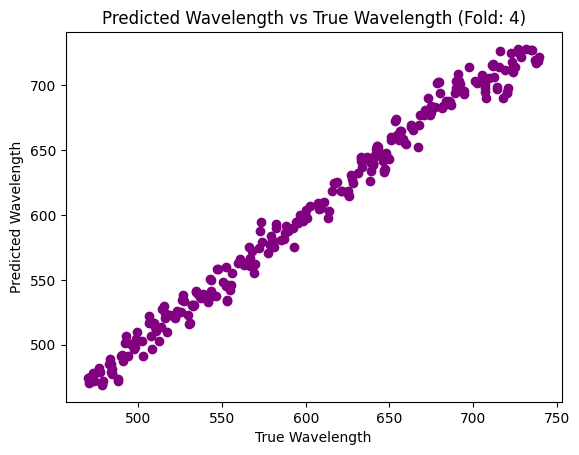

In [30]:
plt.scatter(y_test, y_test_pred, color='purple')
plt.xlabel('True Wavelength')
plt.ylabel('Predicted Wavelength')
plt.title(f'Predicted Wavelength vs True Wavelength (Fold: {best_fold})')
plt.show()

<div align="center">
    <h2>MLP Regression</h2>
</div>

In [31]:
# split the non-test data into training and validation
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train_scaled, y_trainNval, test_size=0.2, random_state=42)

Mean MSE in training set: 3715.78428675005
Mean MSE in validation set: 3610.66373195781
MSE for test data: 125.92464579845957


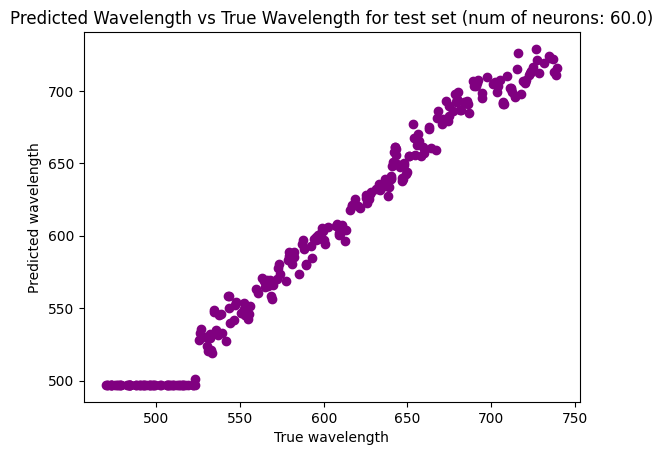

In [33]:
# define number of hidden layers 
initial_neuron = 20
final_neuron = 100
num_steps = 5
num_neurons = np.linspace(initial_neuron, final_neuron, num_steps)

# for storing the errors corresponding to each neuron number
val_errors = []
train_errors = []

# MLP
for i, neuron_count in enumerate(num_neurons):
    # compute the size of the hidden layer
    hidden_layer_sizes = int(neuron_count)
    
    # create MLP Regressor model
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, activation='relu', solver='sgd', max_iter=1000, random_state=42)
    
    # fit the model on trainig data
    model.fit(X_train2, y_train2)
    
    # make predictions on the training data
    y_train_pred2 = model.predict(X_train2)
    
    # make predictions on the validation data
    y_pred2 = model.predict(X_val2)
    
    # calculate MSE on the train and validation data and append it to the val_errors and train_errors
    mse_train2 = mean_squared_error(y_train2, y_train_pred2)
    mse = mean_squared_error(y_val2, y_pred2)
    train_errors.append(mse_train2)
    val_errors.append(mse)

    
    # if this has the min error, calculate for test set
    if mse == min(val_errors):
        y_test_pred2 = model.predict(X_test_scaled)
        best_neurons = neuron_count
        
# compute MSE for the training, validation and test sets
mean_mse_train2 = np.mean(train_errors)
mean_mse_val2 = np.mean(val_errors)
test_mse = mean_squared_error(y_test, y_test_pred2)
print('Mean MSE in training set:', mean_mse_train2)
print('Mean MSE in validation set:', mean_mse_val2)
print('MSE for test data:', test_mse)

plt.scatter(y_test, y_test_pred2, color='purple')
plt.xlabel('True wavelength')
plt.ylabel('Predicted wavelength')
plt.title(f'Predicted Wavelength vs True Wavelength for test set (num of neurons: {best_neurons})')
plt.show()